<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/pbmcIntegrate/pbmcAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname

download_file('10.22002/D1.2175','.tar.gz') 



#os.system("tar -xvf *.tar.gz")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/422469 [00:00<?, ?B/s]

'D1.2175.tar.gz'

In [2]:
!tar -xvf D1.2175.tar.gz

logPBMC.mtx
pca30PBMC.mtx
scalePBMC.mtx
._stimLabsPBMC.csv
stimLabsPBMC.csv
umapPBMC.mtx
logPBMCOrig.mtx


In [3]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 15.88 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [4]:
%cd /content/densvis/densne/

/content/densvis/densne


In [5]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [6]:
%cd /content/

/content


In [7]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 180 (delta 75), reused 77 (delta 17), pack-reused 0
Receiving objects: 100% (180/180), 62.34 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [8]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [9]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 91 kB 7.6 MB/s 
     |████████████████████████████████| 10.2 MB 27.5 MB/s 
     |████████████████████████████████| 69 kB 6.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## **Install Packages**

In [32]:
import statistics
import sklearn.preprocessing
import anndata 
import pandas as pd
import numpy as np

from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


## **Analysis of PBMC Data**
Data from seurat tutotial at https://github.com/satijalab/seurat/blob/master/vignettes/integration_introduction.Rmd

In [11]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

n_latent = 50
pcs = 30 #Following Seurat implementation example


In [12]:
logMat = sio.mmread(data_path+'/logPBMC.mtx').todense()
scaleMat = sio.mmread(data_path+'/scalePBMC.mtx').todense()

pcaMat = sio.mmread(data_path+'/pca30PBMC.mtx').todense()
umapMat = sio.mmread(data_path+'/umapPBMC.mtx').todense()

In [13]:
#Pre-integration matrix
logMatOrig = sio.mmread(data_path+'/logPBMCOrig.mtx').todense()


In [14]:
logMatOrig = logMatOrig.T

In [15]:
logMat = logMat.T
scaleMat = scaleMat.T
scaleMat.shape

(13999, 2000)

In [16]:
conds = pd.read_csv(data_path+'/stimLabsPBMC.csv')
conds.head()

,Unnamed: 0,x
0,AAACATACATTTCC.1,CTRL
1,AAACATACCAGAAA.1,CTRL
2,AAACATACCTCGCT.1,CTRL
3,AAACATACCTGGTA.1,CTRL
4,AAACATACGATGAA.1,CTRL


In [17]:
#Get pca and umap coordinates for original log count matrix 
reducer = umap.UMAP(n_components = ndims, random_state = state)

logScaleOrig = sklearn.preprocessing.scale(logMatOrig)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [18]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(logScaleOrig)



pcaUMAP = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [19]:
# #Get pca and umap coordinates for original log count matrix 
# reducer = umap.UMAP(n_components = ndims, random_state = state)


In [20]:
# #PCA 
# tsvd = TruncatedSVD(n_components=pcs)
# x_pca = tsvd.fit_transform(scaleMat)



# pcaUMAP = reducer.fit_transform(x_pca)


Plot 2D Embeddings

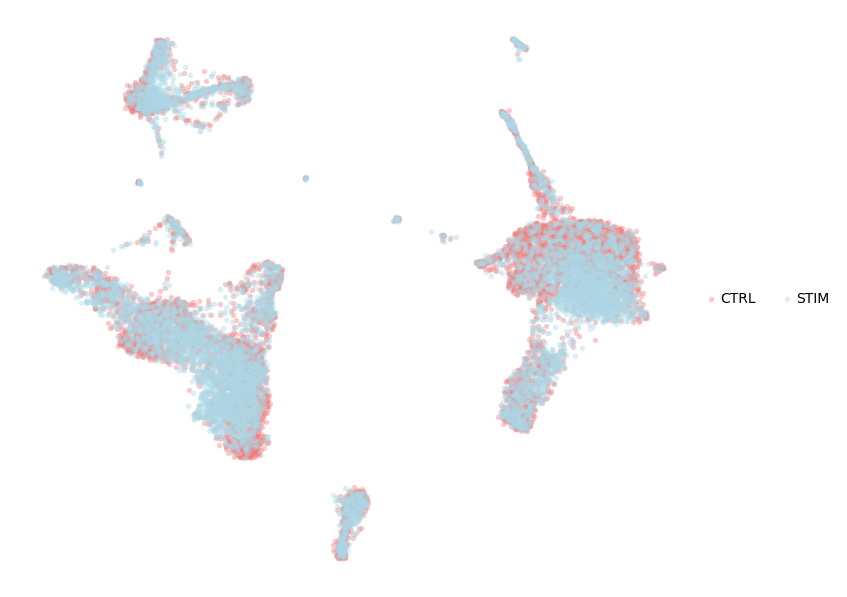

In [21]:
#Scaled/stabilized mat

vis.obj_plot_embed(np.asarray(umapMat), conds['x'], fname = 'stabUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

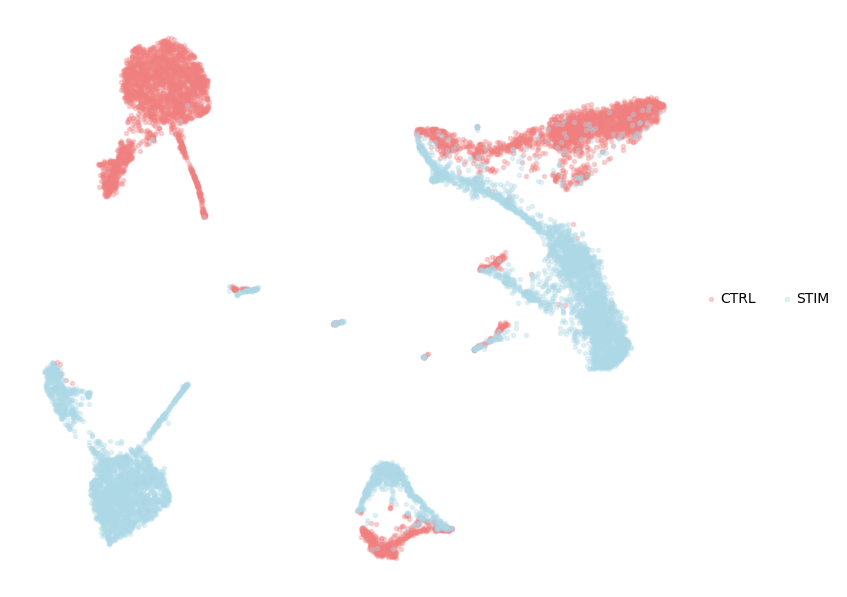

In [22]:
#log mat

vis.obj_plot_embed(pcaUMAP, conds['x'], fname = 'logOrigUMAP.pdf',colors=['lightcoral','lightblue'],alpha = 0.3)

Count neighbor mixing

In [23]:
def frac_unique_neighbors(latent, cluster_label, metric = 1,neighbors = 30):
    """ Calculates the fraction of nearest neighbors from same cell type
    
    Returns:
    output: dictionary mapping each unique label in the category cluster_label
    to the fraction of neighbors in the same cluster, for each point in the cluster
    """
    cats = pd.Categorical(cluster_label)
    # Get nearest neighbors in each space
    n = neighbors
    neigh = NearestNeighbors(n_neighbors=n, p=metric)
    # Get transformed count matrices
    clusters = np.unique(cluster_label)
    unique_clusters = {}
    frac_neighbors = {}
    X_full  = latent
    neigh.fit(X_full)
    for c in clusters:
        X  = latent[cats == c, :]
        # Find n nearest neighbor cells (L1 distance)
        kNeigh = neigh.kneighbors(X)
        matNeigh = kNeigh[1]
        frac = np.zeros(matNeigh.shape[0])
        #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
        unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
        frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
    return frac_neighbors, unique_clusters

Make plots for integrated ambient/embedded data

In [34]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMat), conds['x']) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pcaMat), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(umapMat), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent = ['Log-Normalized Ambient','PCA 30D','30D PCA UMAP']

In [35]:
#Make dataframe

integDF = pd.DataFrame()
integDF['Fraction'] = latents[0] + latents[1] + latents[2]
integDF['Embed'] = ['Log-Normalized Ambient']*len(latents[0]) + ['PCA 30D']*len(latents[1]) + ['30D PCA UMAP']*len(latents[2])
integDF.head()

,Fraction,Embed
0,0.966667,Log-Normalized Ambient
1,0.900000,Log-Normalized Ambient
2,1.000000,Log-Normalized Ambient
3,0.900000,Log-Normalized Ambient
4,0.966667,Log-Normalized Ambient


In [36]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['30D PCA UMAP'])]))

1.0
0.7333333333333333
0.6


<Figure size 1250x625 with 0 Axes>

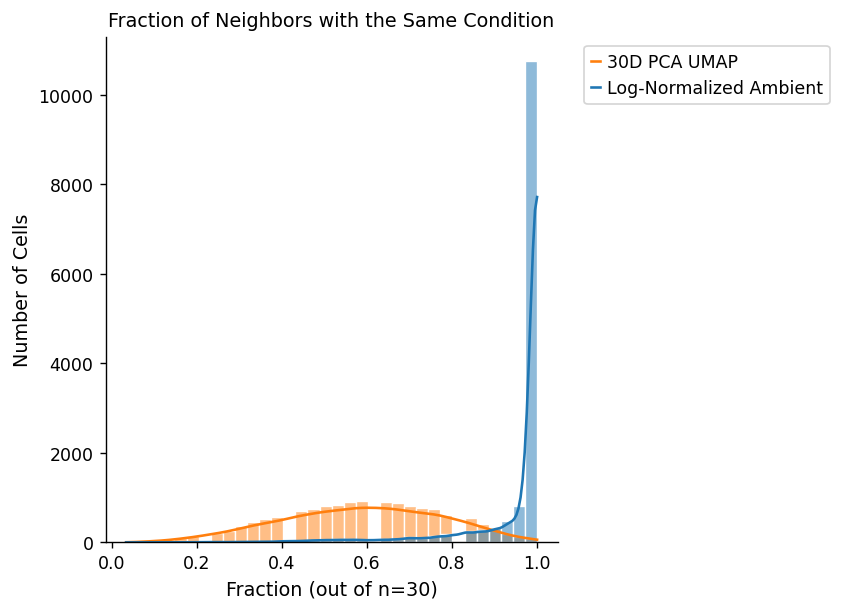

In [37]:
plt.figure(figsize=(10,5))

integDF = integDF[integDF['Embed'].isin(['30D PCA UMAP','Log-Normalized Ambient'])]
g=sns.displot(data=integDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white") #legend=False

plt.legend(['30D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

Make plots for pre-integration matrix + embedding

In [28]:
logNeigh, logClus = frac_unique_neighbors(np.asarray(logMatOrig), conds['x']) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(x_pca), conds['x']) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pcaUMAP), conds['x']) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latent = ['Log-Normalized Ambient (Pre-integration)','PCA 30D','30D PCA UMAP']

In [29]:
#Make dataframe

integDF = pd.DataFrame()
integDF['Fraction'] = latents[0] + latents[1] + latents[2]
integDF['Embed'] = ['Log-Normalized Ambient']*len(latents[0]) + ['PCA 30D']*len(latents[1]) + ['30D PCA UMAP']*len(latents[2])
integDF.head()

,Fraction,Embed
0,1.0,Log-Normalized Ambient
1,1.0,Log-Normalized Ambient
2,1.0,Log-Normalized Ambient
3,1.0,Log-Normalized Ambient
4,1.0,Log-Normalized Ambient


In [30]:
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['PCA 30D'])]))
print(statistics.mode(integDF['Fraction'][integDF['Embed'].isin(['30D PCA UMAP'])]))

1.0
1.0
1.0


<Figure size 1250x625 with 0 Axes>

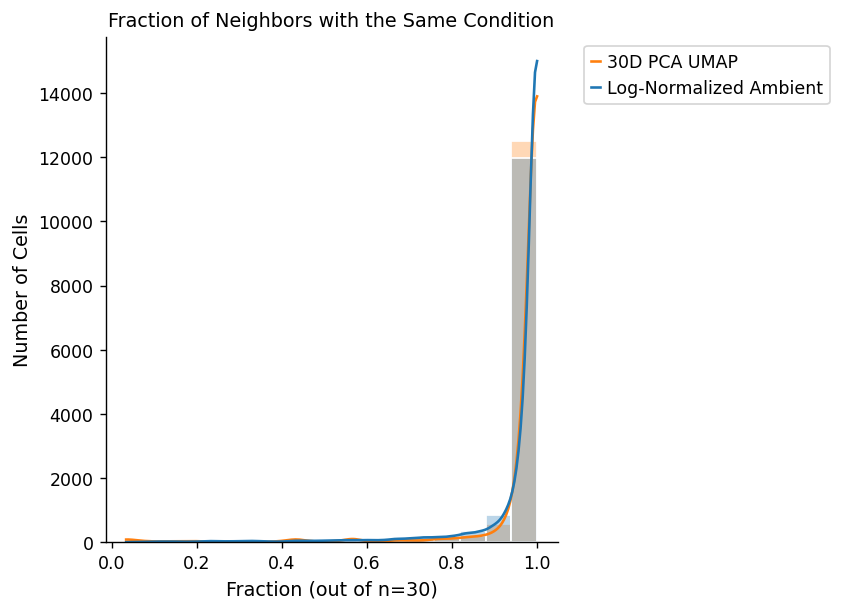

In [33]:
plt.figure(figsize=(10,5))

integDF = integDF[integDF['Embed'].isin(['30D PCA UMAP','Log-Normalized Ambient'])]

g=sns.displot(data=integDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white", alpha=0.3) 

plt.legend(['30D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()